# Análisis Exploratorio de Datos (EDA)

## Carga de datos, limpieza de NaN y librerías necesarias

In [23]:
import pandas as pd
import numpy as np
import plotly.express as px
import os
import folium # (Analisis Geoespacial)

Carga del dataset a utilizar

In [2]:
ruta_dataset = "../data/processed/dataset_final_enriquecido.csv"
df = pd.read_csv(ruta_dataset)
# Aseguramos que la columna 'date' se interprete como fecha, es crucial para la interpolación
df['date'] = pd.to_datetime(df['date'])

print("✅ Dataset enriquecido cargado exitosamente.")
print(f"Dimensiones iniciales: {df.shape}")

✅ Dataset enriquecido cargado exitosamente.
Dimensiones iniciales: (37399, 25)


Imputación de valores faltantes de NOAA mediante datos Open-Meteo

In [5]:
print("\nIniciando limpieza final de NaN...")

# Estrategia A: Rellenar huecos de NOAA con datos de Open-Meteo
mapeo_columnas = {
    'TMAX': 'om_temperature_2m_max', 'TMIN': 'om_temperature_2m_min',
    'TAVG': 'om_apparent_temperature_mean', 'PRCP': 'om_precipitation_sum'
}
for col_noaa, col_om in mapeo_columnas.items():
    if col_noaa in df.columns and col_om in df.columns:
        df[col_noaa] = df[col_noaa].fillna(df[col_om])
        print(f"  -> Huecos en '{col_noaa}' rellenados con datos de '{col_om}'.")

# === CAMBIOS CLAVE AQUÍ ===
# Paso A: Ponemos la fecha como el índice del DataFrame.
df = df.set_index('date')

# Paso B: Ahora la interpolación basada en tiempo funciona.
df = df.interpolate(method='time')

# Paso C: Volvemos a convertir el índice 'date' en una columna normal.
df = df.reset_index()
# ===========================

# Estrategia C: Rellenar cualquier otro posible NaN con 0 (ej. SNWD)
df = df.fillna(0)

print("\n✅ Limpieza final completada. El dataset ya no tiene valores NaN.")


Iniciando limpieza final de NaN...
  -> Huecos en 'TMAX' rellenados con datos de 'om_temperature_2m_max'.
  -> Huecos en 'TMIN' rellenados con datos de 'om_temperature_2m_min'.
  -> Huecos en 'TAVG' rellenados con datos de 'om_apparent_temperature_mean'.
  -> Huecos en 'PRCP' rellenados con datos de 'om_precipitation_sum'.

✅ Limpieza final completada. El dataset ya no tiene valores NaN.


C:\Users\matia\AppData\Local\Temp\ipykernel_32\4289217522.py:19: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df = df.interpolate(method='time')


Verificacion

In [6]:
print("\n--- Información del Dataset 100% Limpio ---")
df.info()


--- Información del Dataset 100% Limpio ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37399 entries, 0 to 37398
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   date                            37399 non-null  datetime64[ns]
 1   station_name                    37399 non-null  object        
 2   PRCP                            37399 non-null  float64       
 3   SNWD                            37399 non-null  float64       
 4   TAVG                            37399 non-null  float64       
 5   TMAX                            37399 non-null  float64       
 6   TMIN                            37399 non-null  float64       
 7   granizo                         37399 non-null  int64         
 8   latitude                        37399 non-null  float64       
 9   longitude                       37399 non-null  float64       
 10  om_weather_code          

Como podemos observar quedo un dataset sin nulos, ya que para los datos faltantes del NOAA se cargaron los que obtuvimos de la API Open-Meteo.
Luego se promediara cada día entre NOAA y Open-Meteo para obtener una estadística más rigurosa sobre los datos estacionales y poder converger en una única medida para el modelo final.

## Ingeniería de Características

In [8]:
# --- Ingeniería de Características (Feature Engineering) ---
# Extraemos el mes de la columna 'date'. El granizo es muy estacional.
df['mes'] = df['date'].dt.month

# --- Característica de Interacción ---
# Calculamos el rango de temperatura diario. Un rango amplio puede indicar inestabilidad.
df['rango_temp_diario'] = df['TMAX'] - df['TMIN']

print("✅ Nuevas características ('mes', 'rango_temp_diario') creadas exitosamente.")
display(df[['date', 'mes', 'TMAX', 'TMIN', 'rango_temp_diario']].head())

✅ Nuevas características ('mes', 'rango_temp_diario') creadas exitosamente.


,date,mes,TMAX,TMIN,rango_temp_diario
0,2000-01-01,1,24.939999,12.7,12.239999
1,2000-01-01,1,32.800000,17.0,15.800000
2,2000-01-01,1,27.896000,17.5,10.396000
3,2000-01-01,1,31.000000,15.2,15.800000
4,2000-01-02,1,28.900000,11.4,17.500000


Esto se realiza ya que el granizo es estacionario, buscamos ver mejor sus patrones climaticos a travez del tiempo

## Análisis Exploratorio de Datos sobre las nuevas variables

### Análisis de Correlación General (Heatmap 2.0)


Generando nuevo heatmap de correlación...
✅ Heatmap guardado exitosamente en: '../reports/figures/02_analisis_enriquecido/'


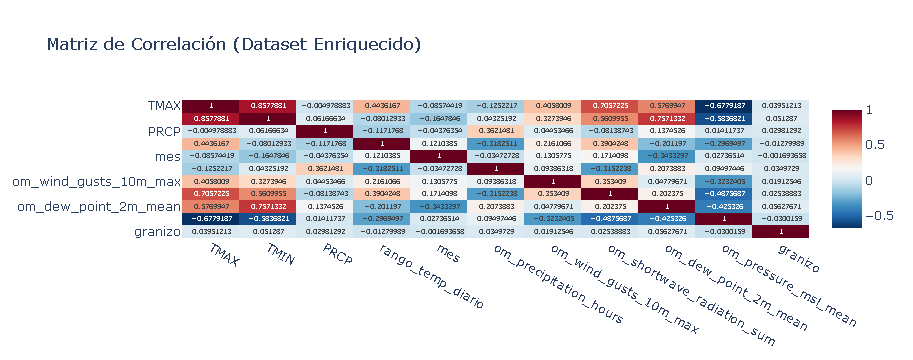

In [18]:
print("\nGenerando nuevo heatmap de correlación...")

# Seleccionamos las variables de interés
columnas_interes = [
    'TMAX', 'TMIN', 'PRCP', 'rango_temp_diario', 'mes',
    'om_precipitation_hours', 'om_wind_gusts_10m_max', 
    'om_shortwave_radiation_sum', 'om_dew_point_2m_mean', 
    'om_pressure_msl_mean', 'granizo'
]
df_seleccion = df[columnas_interes]

# Calculamos la matriz de correlación
matriz_correlacion_pro = df_seleccion.corr()

# Creamos la visualización
fig_heatmap = px.imshow(
    matriz_correlacion_pro,
    text_auto=True,
    aspect="auto",
    color_continuous_scale='RdBu_r',
    title='Matriz de Correlación (Dataset Enriquecido)'
)

# --- PASOS PARA GUARDAR EL GRÁFICO ---
# 1. Definimos la ruta de la carpeta donde guardaremos el gráfico
ruta_carpeta = "../reports/figures/02_analisis_enriquecido/"
# 2. Creamos la carpeta si no existe para evitar errores
os.makedirs(ruta_carpeta, exist_ok=True)
# 3. Guardamos la figura como un archivo HTML
fig_heatmap.write_html(ruta_carpeta + "heatmap_correlacion_enriquecido.html")

print(f"✅ Heatmap guardado exitosamente en: '{ruta_carpeta}'")
# ------------------------------------

# Mostramos el gráfico en la notebook
fig_heatmap.show()

Ahora, luego de ver estos resultados para un mejor entendimiento, se listaran las correlaciones del granizo con sus variables:
* granizo - tmax= 0.0395
* granizo - tmin= 0.051287
* granizo - prcp = 0.02981
* granizo - rango_temp_diario = -0.0127
* granizo - mes = -0.0169
* granizo - om_precipitation_hours = 0.034972
* granizo - om_wild_gust_10m_max= 0.019121
* granizo - om_shortwave_radiation_sum = 0.025388
* granizo - om_dew_point_2m_mean = 0.05627711
* granizo - om_preassure_msl_mean = -0.0300159

Este resultado, lejos de ser un problema, es la justificación más sólida que podríamos tener para usar una red neuronal.
Confirma que la “receta” del granizo no depende de un solo ingrediente fuerte. Es una combinación muy sutil y no lineal de muchos ingredientes débiles. Un modelo simple no podría encontrarla, pero una red neuronal está diseñada precisamente para detectar esos patrones complejos.

### Box Plot: Punto de Rocío vs. Evento de Granizo

Generando box plot para el Punto de Rocío...
✅ Box plot guardado exitosamente en: '../reports/figures/02_analisis_enriquecido/'


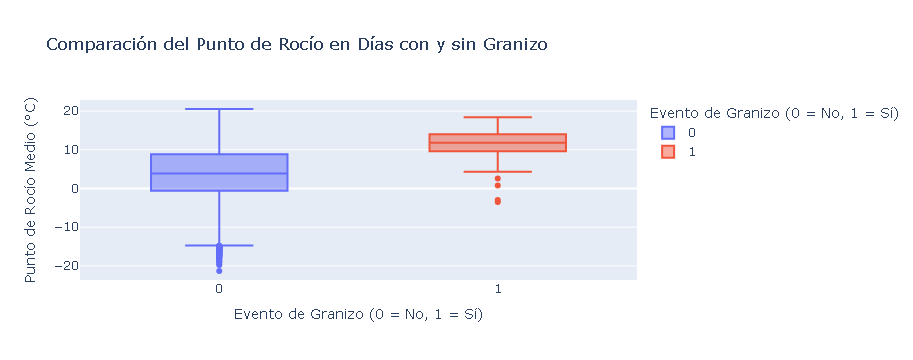

In [20]:
print("Generando box plot para el Punto de Rocío...")

# Creamos el box plot
fig_dew_point = px.box(
    df,
    x='granizo',
    y='om_dew_point_2m_mean',
    color='granizo',
    title='Comparación del Punto de Rocío en Días con y sin Granizo',
    labels={
        "granizo": "Evento de Granizo (0 = No, 1 = Sí)",
        "om_dew_point_2m_mean": "Punto de Rocío Medio (°C)"
    }
)

# --- Guardamos el gráfico ---
ruta_carpeta = "../reports/figures/02_analisis_enriquecido/"
os.makedirs(ruta_carpeta, exist_ok=True)
fig_dew_point.write_html(ruta_carpeta + "boxplot_dewpoint_vs_granizo.html")

print(f"✅ Box plot guardado exitosamente en: '{ruta_carpeta}'")
# -----------------------------

fig_dew_point.show()

Este es el gráfico más claro que hemos visto hasta ahora. Nos dice que la humedad es un ingrediente absolutamente crítico.

Observación Clave: La caja roja (días con granizo) está completamente por encima de la caja azul (días sin granizo).
Prácticamente, no hay superposición entre los rangos principales de ambas.

Insight: Los días de granizo son siempre días con alta humedad. Si el aire está seco (punto de rocío bajo), la probabilidad de granizo es casi nula. Esta será una de las variables más importantes para tu modelo.

### Box Plot: Ráfagas de Viento vs. Evento de Granizo

Generando box plot para las Ráfagas de Viento...
✅ Box plot guardado exitosamente en: '../reports/figures/02_analisis_enriquecido/'


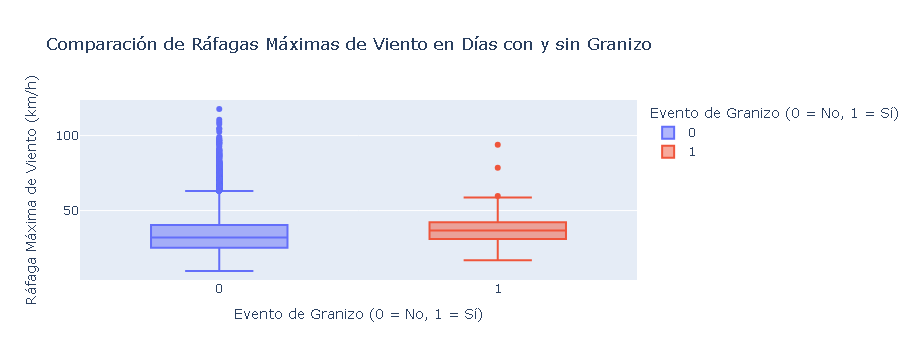

In [21]:
print("Generando box plot para las Ráfagas de Viento...")

# Creamos el box plot
fig_wind_gusts = px.box(
    df,
    x='granizo',
    y='om_wind_gusts_10m_max',
    color='granizo',
    title='Comparación de Ráfagas Máximas de Viento en Días con y sin Granizo',
    labels={
        "granizo": "Evento de Granizo (0 = No, 1 = Sí)",
        "om_wind_gusts_10m_max": "Ráfaga Máxima de Viento (km/h)"
    }
)

# --- Guardamos el gráfico ---
ruta_carpeta = "../reports/figures/02_analisis_enriquecido/"
os.makedirs(ruta_carpeta, exist_ok=True)
fig_wind_gusts.write_html(ruta_carpeta + "boxplot_windgusts_vs_granizo.html")

print(f"✅ Box plot guardado exitosamente en: '{ruta_carpeta}'")
# -----------------------------

fig_wind_gusts.show()

Este gráfico también es muy bueno. Confirma que el granizo está asociado con vientos fuertes.

Observación Clave: La caja roja está notablemente más alta que la azul. La velocidad mediana de las ráfagas en días de granizo es claramente mayor que en los días normales.

Insight: El modelo aprenderá que, si bien puede haber días ventosos sin granizo, los días de granizo casi nunca son días calmos. Las ráfagas de viento son un buen indicador de la severidad de una tormenta.


#### Conclusión General y Próximo Paso

Con estos últimos gráficos, hemos completado un perfil meteorológico muy completo del “día de granizo” ideal según nuestros datos:

Una noche cálida (TMIN alta), un día caluroso (TMAX alta), con mucha humedad (punto de rocío alto) y vientos fuertes (ráfagas altas).

Hemos terminado la parte del análisis que compara variables. El siguiente paso en nuestro plan es el Análisis Geoespacial: el mapa de "hotspots" para ver si estos 95 eventos que encontramos se concentran en alguna estación en particular.

## Análisis Exploratorio de Datos geo espacial

In [24]:
print("Creando mapa de hotspots de granizo...")

# 1. Calculamos el total de días de granizo por cada estación
resumen_granizo = df[df['granizo'] == 1].groupby('station_name').agg(
    # Obtenemos la lat/lon y contamos el número de eventos de granizo
    latitude=('latitude', 'first'),
    longitude=('longitude', 'first'),
    total_dias_granizo=('granizo', 'count')
).reset_index()

# 2. Creamos el mapa base, centrado en Mendoza
mapa_eventos = folium.Map(location=[-34.6, -68.5], zoom_start=7)

# 3. Añadimos un círculo por cada estación
if not resumen_granizo.empty:
    for index, station in resumen_granizo.iterrows():
        folium.Circle(
            location=[station['latitude'], station['longitude']],
            # El radio del círculo será proporcional al número de eventos
            # Le sumamos un mínimo y multiplicamos para que sea visible
            radius=(station['total_dias_granizo'] * 50) + 500,
            color='crimson',
            fill=True,
            fill_color='crimson',
            # El popup mostrará la información al hacer clic
            popup=f"{station['station_name']}<br>Eventos de Granizo: {station['total_dias_granizo']}"
        ).add_to(mapa_eventos)
    print("✅ Círculos de eventos añadidos al mapa.")
else:
    print("No se encontraron eventos de granizo para graficar.")

# --- Guardamos el mapa ---
ruta_carpeta = "../reports/figures/02_analisis_enriquecido/"
os.makedirs(ruta_carpeta, exist_ok=True)
mapa_eventos.save(ruta_carpeta + "mapa_hotspots_granizo.html")
print(f"✅ Mapa guardado exitosamente en: '{ruta_carpeta}'")
# --------------------------

# 4. Mostramos el mapa en la notebook
display(mapa_eventos)

Creando mapa de hotspots de granizo...
✅ Círculos de eventos añadidos al mapa.
✅ Mapa guardado exitosamente en: '../reports/figures/02_analisis_enriquecido/'
